<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt

from clawpack import pyclaw
from clawpack import riemann

# Convergence, Accuracy, and Stability

For real world problems in science and engineering it is often difficult to find true solutions of any complexity (or at all).  Instead we rely on a process called **Verification and Validation** or **V&V**.  This refers to a two step process rougly described by the following.
 - **Verification** is the theoretical analysis including convergence and accuracy showing that a chosen numerical method performs as expected.  
 - **Validation** is the process of comparing the numerical solution obtained from a numerical method on a test problem, either analytical or observed or experimental data.
 
We will concentrate on the former but the entire process V&V is important.

## Convergence

The first step in our discussion is to establish a form of error.  For finite differences the point-wise values are often used and differenced from the true point-wise values.  For finite volume methods it is much more natural to use cell-wise averages.

Let $q(x, t_n)$ be the true solution evaluated at time $t_n$.  Define
$$
    q^n_i = \frac{1}{\Delta x} \int_{\mathcal{C}_i} q(x, t_n) dx
$$
as the exact cell-average then.  Note that for q(x, t_n) sufficiently smooth the point-wise evaluation at cell centers and the cell-averages will will agree to $\mathcal{O}(\Delta x^2)$.

Now define the global error as
$$
    E^N = Q^N - q^N
$$
where our finite final time $T$ is defined by $T = N \Delta t$.  Note that as $\Delta t \rightarrow 0$ that $N \rightarrow \infty$.

Often times we will also assume that there is a fixed relationship between $\Delta x$ and $\Delta t$, such as the CFL condition, to simplify our analysis.

### Norms

Next up is a choice of norms.  We of course can rely on the $p$-norms
$$
    ||E||_p = \left(\Delta x \sum^\infty_{i=-\infty} |E_i|^p \right )^{1/p}
$$
for vectors and
$$
    ||E||_p = \left( \int^\infty_{i=-\infty} |E(x)|^p dx \right )^{1/p}
$$
for functions.

The $p=1$ norm is of particular for conservation laws as integrals of the solution itself are often of interest.

Now that we have our basic definitions we can define convergence.

A method is **convergent** at time $T$ in the norm $||\cdot||$ if 
$$
    \lim_{\Delta t \rightarrow 0, N \Delta t = T} ||E^N|| = 0.
$$

A method is **accurate of order s** if
$$
    ||E^N|| = \mathcal{O}(\Delta t^s) \quad \Delta t \rightarrow 0.
$$

Note that if $q(x,t)$ is smooth we could also define point-wise convergence.  However we already know that hypernbolic PDEs can contain discontinuities and we cannot expect convergence in the max norm.  There are many other caveats that discontinuities in our solutions will provide and we will talk about them as they arise.

## One-Step and Local Truncation Errors

Almost always it is very difficult to directly prove convergence.  Instead we often show two properties of a method:

1. The method is **consistent** with the original equation.  This is the same as analysis on error produced in one step of the method or the local error.
1. The method is **stable**.  Errors produced in previous time steps do not grow catastrophically and therefore the global error is directly dependent on local errors.

The **fundamental theorem of numerical methods** implies that if a method is both consistent and stable that it is convergence.  This is sometimes called the Lax equivalence theorem or Dahlquist's equivalence theorem, for PDEs and ODEs respectively.

An explicit, one-step numerical method can be written as
$$
    Q^{n+1}_i = \mathcal{N}(Q^n_i)
$$
Note that $\mathcal{N}(\cdot)$ can be multi-stage or non-linear but fundamentally requires only the currently known time to get the next time step.

The **one-step error** can then be defined as
$$
    \widetilde{\tau}^n = \mathcal{N}(q^n) - q^{n+1}
$$
Notice that the method is receiving EXACT data to produce the next time step in this case.

Instead we can also define the **local truncation error**, or LTE, as
$$
    \tau^n = \frac{1}{\Delta t} [\mathcal{N}(q^n) - q^{n+1}).
$$
Here we have purposefully related the one-step to the local truncation error making explicit the division by $\Delta t$.  LTE will end up being more useful as it is directly related to the global error.

LTE is also important as it allows us define consistency at this point.  A **consistent** method is one for which
$$
    \tau^n \rightarrow 0 \text{ as } \Delta t \rightarrow 0.
$$

#### Example: Upwinding

Consider the first-order upwinding method
$$
    Q^{n+1}_i = Q^n_i - \frac{u \Delta t}{\Delta x}(Q^n_i - Q^n_{i-1})
$$
with $u > 0$.  Compute the local truncation error, confirming that the method is first-order and therefore consistent.

This can simply be computed by plugging in the method into the equation for LTE.  First we need the following Taylor series expansions:
$$\begin{aligned}
    q^n_{i-1} &= q^n_i - \Delta x (q^n_i)_x + \frac{\Delta x^2}{2} (q^n_i)_{xx} + \mathcal{O}(\Delta x^3) \\
    q^{n+1}_{i} &= q^n_i + \Delta t (q^n_i)_t + \frac{\Delta t^2}{2} (q^n_i)_{tt} + \mathcal{O}(\Delta t^3)
\end{aligned}$$
Now we can finish the LTE computation:
$$\begin{aligned}
    \tau^n &= \frac{1}{\Delta t} \left[q^n_i - \frac{u \Delta t}{\Delta x} (q^n_i - q^n_{i-1}) - q^{n+1}_i \right ] & & \\
    &= \frac{1}{\Delta t} \left \{ q^n_i - \frac{u \Delta t}{\Delta x} \left[q^n_i - \left(q^n_i - \Delta x (q^n_i)_x + \frac{\Delta x^2}{2} (q^n_i)_{xx} + \mathcal{O}(\Delta x^3) \right)\right] \right . & & \text{Taylor Series} \\
    & \left . \quad \quad \quad - \left(q^n_i + \Delta t (q^n_i)_t + \frac{\Delta t^2}{2} (q^n_i)_{tt} + \mathcal{O}(\Delta t^3) \right) \right \} & & \\
    &= -[(q^n_i)_t + u (q^n_i)_x] + \frac{1}{2} \Delta x u (q^n_i)_{xx} - \frac{1}{2} \Delta t (q^n_i)_{tt} + \mathcal{O}(\Delta x^2, \Delta t^2) & & \text{Simplify}
\end{aligned}$$
The first term is identically zero as it is the equation we are solving leading us to the conclusion that $\tau^n = \mathcal{O}(\Delta x, \Delta t)$.

## Stability Theory

Stability theory is concerned with gauranteeing that the local errors made in previous time steps do not catastrophically blow up in future time steps.  Here we will study the general concepts and a number of ways to show stability for methods we have already discussed.}

First rewrite the global error as
$$
    Q^n = q^n + E^n.
$$
Now apply the numerical method $\mathcal{N}(\cdot)$ to this data so that we have
$$
    Q^{n+1} = \mathcal{N}(Q^n) = \mathcal{N}(q^n + E^n)
$$
so that
$$\begin{aligned}
    E^{n+1} &= Q^{n+1} - q^{n+1} \\
    &= \mathcal{N}(q^n + E^n) - q^{n+1} \\
    &= \mathcal{N}(q^n + E^n) - \mathcal{N}(q^n) + \mathcal{N}(q^n) - q^{n+1} \\
    &= [\mathcal{N}(q^n + E^n) - \mathcal{N}(q^n)] + \Delta t \tau^n.
\end{aligned}$$
Note that this has now separated the global error into two pieces, the error that occured locally represented by the LTE and one based on the previous numerical error.

### Contractive Operators

A **contractive operator** is an operator $\mathcal{N}(\cdot)$ in some norm that satisfies
$$
    ||\mathcal{N}(P) - \mathcal{N}(Q) || \leq ||P-Q||
$$
for any two grid functions $P$ and $Q$.

If $\mathcal{N}$ is contractive then the method represented by $\mathcal{N}$ is also stable in this norm.

Let's apply this idea to our case.  Let $P = q^n + E^n$ and $Q = q^n$:
$$\begin{aligned}
    ||E^{n+1}|| &\leq ||\mathcal{N}(q^n + E^n) - \mathcal{N}(q^n)|| + \Delta t ||\tau^n|| \\
   & \leq ||E^n|| + \Delta t ||\tau^n||.
\end{aligned}$$

Applying this recursively then leads to
$$
    ||E^n|| \leq ||E^0|| + \Delta t \sum^{N-1}_{n=1} ||\tau^n||.
$$

Now suppose that 
$$
    ||\tau|| \equiv \max_{0 \leq n \leq N} ||\tau^n||
$$
so that we can then write
$$\begin{aligned}
    ||E^N|| &\leq ||E^0|| + N \Delta t ||\tau|| \\
    &\leq ||E^0|| + T ||\tau||
\end{aligned}$$

### Lax-Richtmyer Stability for Linear Methods

We actually can require something slighly weaker as a sufficient condition that $\mathcal{N}$ is stable.  If we have instead
$$
    ||\mathcal{N}(P) - \mathcal{N}(Q) || \leq (1 + \alpha \Delta t) ||P - Q||
$$
where $\alpha$ is a constant indepdent of $\Delta t$ we can still show convergence.

We now have
$$
    ||E^{n+1}|| \leq (1 + \alpha \Delta t) ||E^n|| + \Delta t ||\tau||
$$
implying
$$\begin{aligned}
    ||E^n|| &\leq (1+\alpha \Delta t)^N ||E^0|| + \Delta t \sum^{N-1}_{n=1} (1 + \alpha \Delta t)^{N - 1 - n} ||\tau|| \\
    &\leq e^{\alpha T} (||E^0|| + T ||\tau||) \quad (\text{for } N\Delta t = T).
\end{aligned}$$

Generally this type of stability if $\mathcal{N}$ is linear is **Lax-Richtmyer Stability** that can be expressed as
$$
    ||\mathcal{N}|| \leq 1 + \alpha \Delta t.
$$

### 2-Norm Stability and von Neumann Analysis

When a method is again linear we can turn to Fourier analysis to provide an easy means to prove stability.  This is the basis of **von Neumann stability**, which we will examine here.

Let $Q^n_j$ represent an arbitrary grid function for the Cauchy problem.  Suppose that $||Q^n_j||_2 < \infty$ so that we can express the grid function as
$$
    Q^n_j = \frac{1}{\sqrt{2 \pi}} \int^\infty_{-\infty} \widehat{Q}(\xi) e^{i \xi j \Delta x} d\xi
$$
If we apply a LINEAR function $\mathcal{N}$ to $Q^n_j$ we can find the update
$$
    Q^{n+1}_j = \frac{1}{\sqrt{2 \pi}} \int^\infty_{-\infty} \widehat{Q}(\xi) g(\xi, \Delta x, \Delta t) e^{i \xi j \Delta x} d\xi
$$
where $g(\cdot)$ represents the **amplification factor** for wave number $\xi$ of the method.  We can rewrite this more helpfully as
$$
    \widehat{Q}^{n+1}(\xi) = g(\xi, \Delta x, \Delta t) \widehat{Q}^n(\xi).
$$

Recall that **Parseval's relation** states that
$$
    ||Q^n||_2 = ||\widehat{Q}^n||_2
$$
where
$$
    ||Q^n||_2 = \left (\Delta x \sum^\infty_{j=-\infty} |Q^n_i|^2 \right )^{1/2} \quad \quad ||\widehat{Q}^n||_2 = \left (\int^\infty_{j=-\infty} |\widehat{Q}^n(\xi)|^2 d\xi \right )^{1/2}
$$
This of course implies that if we can show boundedness of the Fourier transform that we have also shown the boundedness of the original function.

Turning back to therefore proving the boundedness of $\widehat{Q}$ then we consider single wave number data of the form
$$
    Q^n_j = e^{i \xi j \Delta x}.
$$
As long as $\xi$ remains arbitrary we can consider the single wave number form of solutions.  Therefore, if we can show that the amplification factor from
$$
    \widehat{Q}^{n+1}(\xi) = g(\xi, \Delta x, \Delta t) \widehat{Q}^n(\xi)
$$
that $|g| \leq 1$ we have proven what we set out to.

#### Example:  Upwind

Again consider the upwind method, a linear, explicit, one-step method.  Writing the upwind method with $u > 0$ and directly using the Courant number $\nu$ we have
$$\begin{aligned}
    Q^{n+1}_j &= Q^n_j - \nu (Q^n_j = Q^n_{j - 1}) \\
    &= (1 - \nu) Q^n_j + \nu Q^n_{j - 1} \\
\end{aligned}$$
Plugging $Q^n_j = e^{i \xi j \Delta x}$ into the above expression leads to
$$\begin{aligned}
    Q^{n+1}_j &= (1 - \nu) Q^n_j + \nu Q^n_{j - 1} \\
    &= (1 - \nu) e^{i \xi j \Delta x} + \nu e^{-i \xi \Delta x} e^{i \xi j \Delta x} \\
    &= [(1 - \nu) + \nu e^{-i \xi\Delta x} ] e^{i \xi j \Delta x} \\
    &= g(\xi, \Delta x, \Delta t) Q^n_j.
\end{aligned}$$

So we know that we have
$$
    g(\xi, \Delta x, \Delta t) = (1 - \nu) + \nu e^{-i \xi\Delta x}.
$$
Since $-1 \leq e^{-i \xi\Delta x} \leq 1$ we are not worried about that assuming $-1 \leq \nu \leq 1$.  Of course this also holds for the first term and we see that if the CFL condition is statisfied the method is stable.

### 1-Norm Stability of the Upwind Method

As mentioned before, the 1-norm is often used for conservation laws, especially in the case of nonlinear PDEs.  Again we will consider the upwind in the form
$$
    Q^{n+1}_i = (1- \nu) Q^n_i + \nu Q^n_{i-1}.
$$

Applying the 1-norm we have
$$\begin{aligned}
    ||Q^{n+1}||_1 &= \Delta x \sum_i |Q^{n+1}_i| & & \\
    &= \Delta x \sum_i |(1-\nu)Q^n_i + \nu Q^n_{i-1}| & & \\
    &\leq \Delta x \sum_i [(1-\nu) |Q^n_i| + \nu |Q^n_{i-1}| ] & & \text{Triangle Inequality} \\
    ||Q^{n+1}||_1 &\leq (1-\nu) ||Q^n||_1 + \nu ||Q^n||_1 = ||Q^n||_1 & &
\end{aligned}$$
This only works if $0 \leq \nu \leq 1$.

### Total-Variation Stability for Nonlinear Method

Many of the above stability proofs relied on the method being linear.  For non-linear methods we turn to our ideas of total variation.

A numerical methods is **total-variation bounded** (TVB) if, for any data $Q^0$ with $TV(Q^0) < \infty$ and time $T$, there is a constant $R > 0$ and $\Delta t_0 > 0$ s.t.
$$
    \text{TV}(Q^n) \leq R \quad \forall n \Delta t \leq T \quad \text{when} \Delta t < \Delta t_0
$$

In other words we require a uniform bound on the total variation up to a time $T$.

We actually require something a bit less strict as we can again use a bound such that
$$
    \text{TV}(Q^{n+1}) \leq (1 + \alpha \Delta t) \text{TV}(Q^n)
$$
again for an $\alpha$ constant independent of $\Delta t$.

## Accuracy at Extrema

The TVD methods we have already discussed are sufficient to show stability but not neccesary.  We would be better off choosing Lax-Wendroff for instance near smooth extrema.  This leads to a number of other methods that attempt to maintain stability but also smooth extrema such as the **esentially nonoscillatory** (ENO) method family.

## Order of Accuracy is Not Everything

Unfortunately our usual metric of order of accuracy is not always a proper metric for judging a method.  In fact a high-order of accuracy method may not be as accurate on a particular grid as a low order method.  One example of this is a grid that is aligned such that it exactly solves the method but is first-order.  We will now consider other situations where this may also be true.

Consider the error expression
$$
    ||E^N|| = C(\Delta x)^2 + \text{higher-order terms}.
$$
There's a lot that can go wrong here, for instance $C$ may be large and the higher-order terms may be imporant apart from $\Delta x \rightarrow 0$.

Here the most important piece that may not adhere to order of accuracy are discontinuities in our solution.  We can also show that even given a smooth solution that a limiter method will perform better than a strictly Lax-Wendroff based method.

2025-10-16 13:30:57,947 INFO CLAW: Solution 0 computed for time t=0.000000
2025-10-16 13:30:57,949 INFO CLAW: Solution 1 computed for time t=0.200000
2025-10-16 13:30:57,951 INFO CLAW: Solution 2 computed for time t=0.400000
2025-10-16 13:30:57,953 INFO CLAW: Solution 3 computed for time t=0.600000
2025-10-16 13:30:57,955 INFO CLAW: Solution 4 computed for time t=0.800000
2025-10-16 13:30:57,956 INFO CLAW: Solution 5 computed for time t=1.000000
2025-10-16 13:30:57,959 INFO CLAW: Solution 6 computed for time t=1.200000
2025-10-16 13:30:57,962 INFO CLAW: Solution 7 computed for time t=1.400000
2025-10-16 13:30:57,964 INFO CLAW: Solution 8 computed for time t=1.600000
2025-10-16 13:30:57,967 INFO CLAW: Solution 9 computed for time t=1.800000
2025-10-16 13:30:57,969 INFO CLAW: Solution 10 computed for time t=2.000000
2025-10-16 13:30:57,973 INFO CLAW: Solution 0 computed for time t=0.000000
2025-10-16 13:30:57,976 INFO CLAW: Solution 1 computed for time t=0.200000
2025-10-16 13:30:57,979 

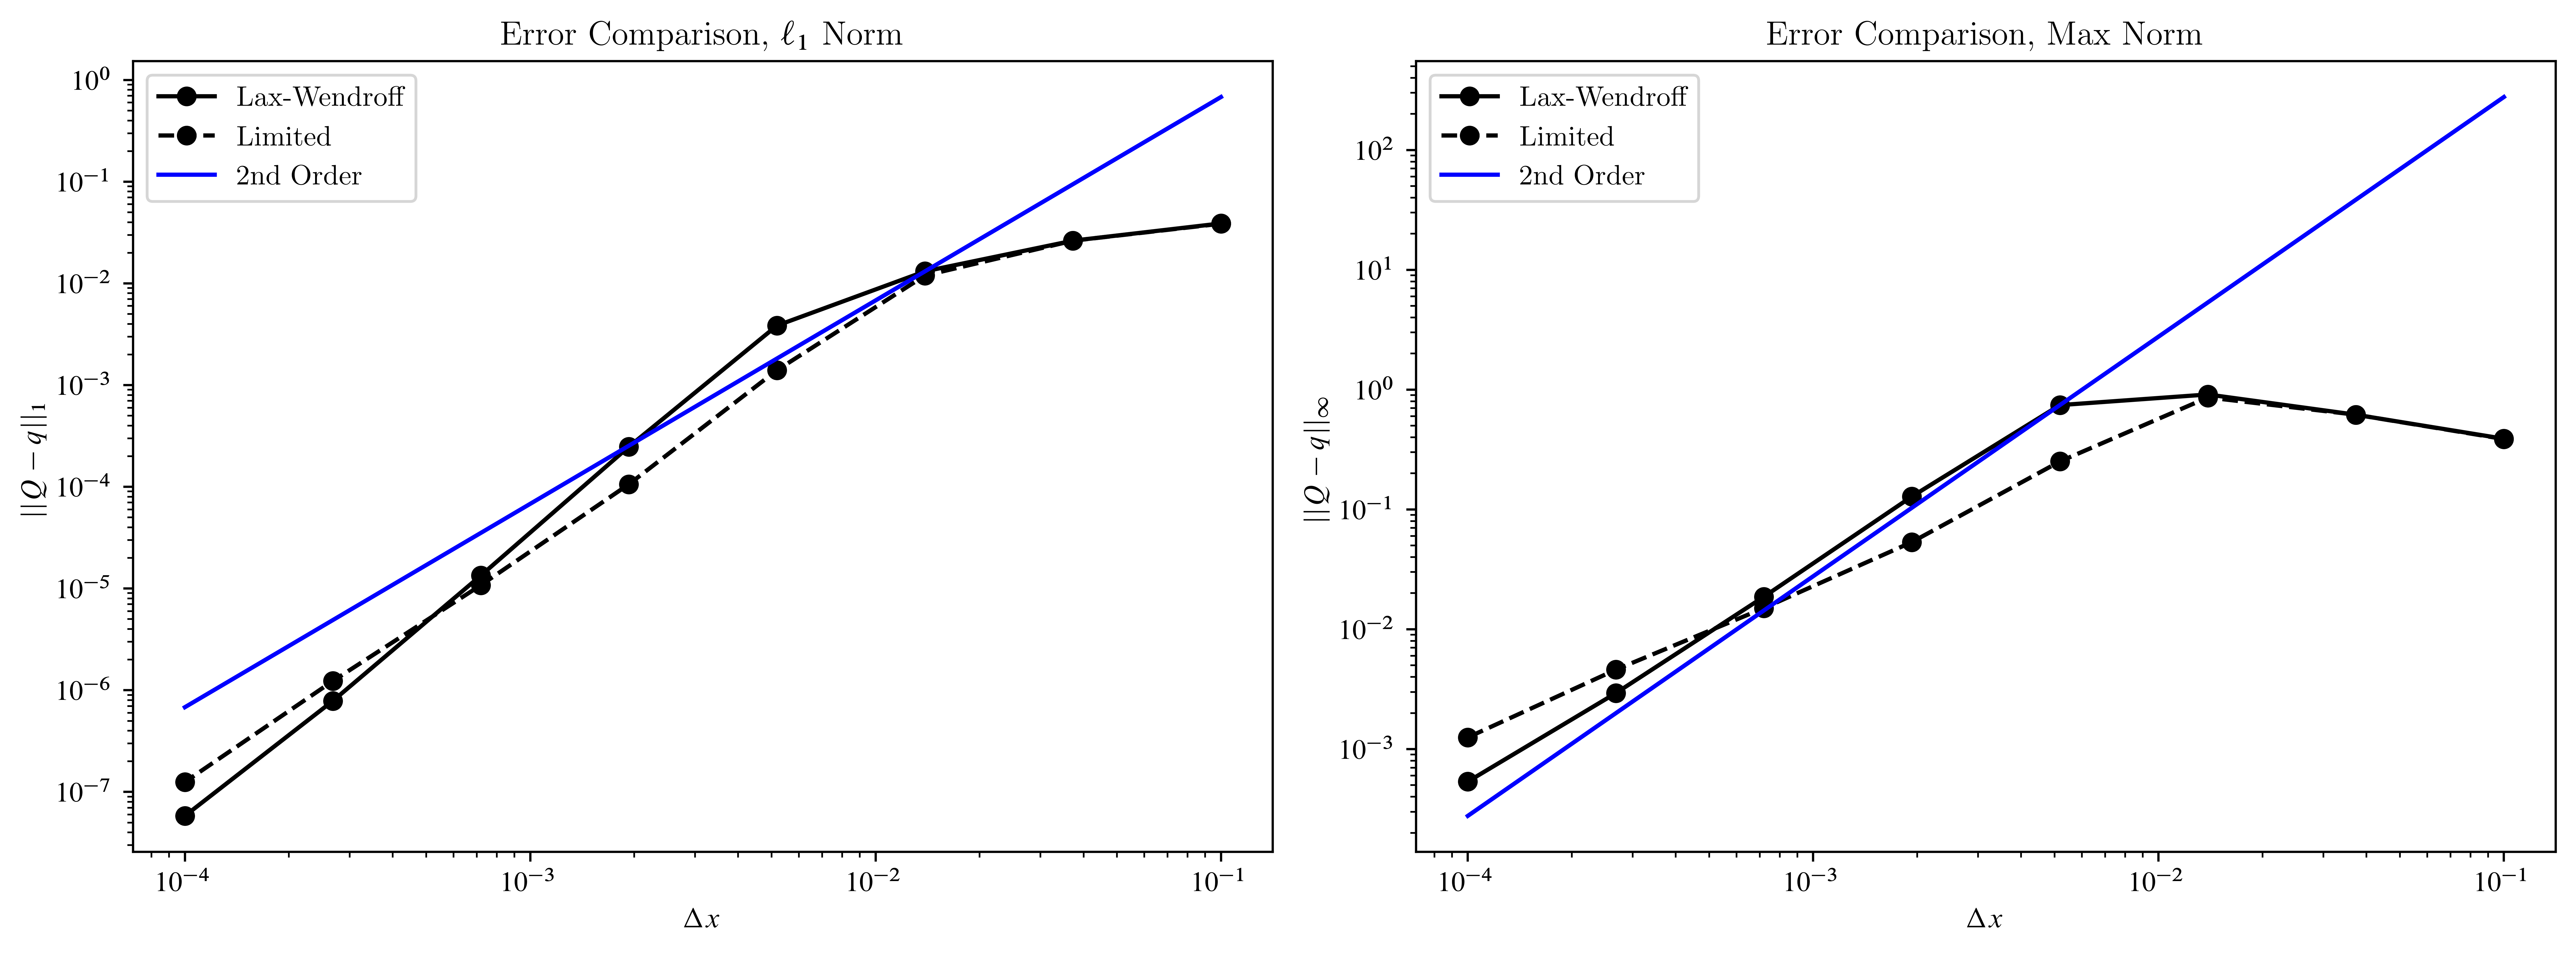

In [2]:
def run_simulation(dx, limiters=[0]):

    solver = pyclaw.ClawSolver1D(riemann.advection_1D)

    solver.bc_lower[0] = 2
    solver.bc_upper[0] = 2
    solver.limiters = limiters
    solver.order = 2
    solver.cfl_desired = 0.9

    mx = 1.0 / dx + 2
    x = pyclaw.Dimension(0.0, 1.0, mx, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    state = pyclaw.State(domain, num_eqn)
    state.problem_data['u'] = 1.0

    xc = domain.grid.x.centers
    beta=100.; x0=0.5; mx=100
    state.q[0,:] = numpy.exp(-beta * (xc-x0)**2) * numpy.sin(80.*xc)
    # beta=200.; x0=0.3; mx=100
    # state.q[0,:] = numpy.exp(-beta * (xc-x0)**2) + (xc>0.6)*(xc<0.8)

    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.tfinal = 2.0
    claw.keep_copy = True

    claw.run()

    return claw.frames[-1].q

def compute_lax_wendroff(dx):
    return run_simulation(dx, limiters=[0])

def compute_limited(dx, limiters=[4]):
    return run_simulation(dx, limiters=limiters)

def true_solution(dx, t):

    mx = int(1.0 / dx + 2)
    xtrue = numpy.linspace(0.0, 1.0, mx)
    xshift = numpy.mod(xtrue - t, 1.0)
    # x1 = 0.6; x2 = 0.8; beta=200.; x0=0.3
    # return numpy.exp(-beta * (xshift-x0)**2) + (xshift>0.6)*(xshift<0.8)

    beta=100.; x0=0.5; mx=100
    return numpy.exp(-beta * (xshift-x0)**2) * numpy.sin(80.*xshift)
    
plot_solution = False

deltas = numpy.logspace(-1, -4, 8)
error_lax_L1 = []
error_mc_L1 = []
error_lax_max = []
error_mc_max = []
for dx in deltas:
    Q = compute_lax_wendroff(dx)
    error_lax_L1.append(numpy.linalg.norm(dx * (Q 
                                          - true_solution(dx, 2.0)), 1))
    error_lax_max.append(numpy.max(Q - true_solution(dx, 2.0)))
    Q = compute_limited(dx)
    error_mc_L1.append(numpy.linalg.norm(dx * (Q
                                         - true_solution(dx, 2.0)), 1))
    error_mc_max.append(numpy.max(Q - true_solution(dx, 2.0)))

if plot_solution:
    fig, axes = plt.subplots(1, 1)
    x = numpy.linspace(0, 1, 100)
    q = compute_lax_wendroff(x[1]-x[0])[0]
    axes.plot(x, compute_lax_wendroff(x[1]-x[0])[0], 'xr')
    axes.plot(x, compute_limited(x[1] - x[0])[0], 'ob')
    axes.plot(x, true_solution(x[1]-x[0], 2.0), 'k-')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)

axes[0].loglog(deltas, error_lax_L1, 'ko-', label="Lax-Wendroff")
axes[0].loglog(deltas, error_mc_L1, 'ko--', label="Limited")
axes[0].set_title("Error Comparison, $\ell_1$ Norm")
axes[0].set_xlabel("$\Delta x$")
axes[0].set_ylabel("$||Q - q||_1$")
axes[0].loglog(deltas, order_C(deltas[2], error_lax_L1[2], 2.0) * deltas**2.0, 'b', label="2nd Order")
axes[0].legend()

axes[1].loglog(deltas, error_lax_max, 'ko-', label="Lax-Wendroff")
axes[1].loglog(deltas, error_mc_max, 'ko--', label="Limited")
axes[1].set_title("Error Comparison, Max Norm")
axes[1].set_xlabel("$\Delta x$")
axes[1].set_ylabel("$||Q - q||_\infty$")
axes[1].loglog(deltas, order_C(deltas[3], error_lax_max[3], 2.0) * deltas**2.0, 'b', label="2nd Order")
axes[1].legend()

plt.show()

## Modified Equations

One way we can start to understand numerical methods is to find the modified equations that equate to the method, i.e. the equation we are actually solving.  This is best shown by example.

#### Example: The Upwind Method

Again consider the upwind method with $u > 0$ for the advection equation:
$$
    Q^{n+1}_i = Q^n_i - \frac{u \Delta t}{\Delta x} (Q^n_i - Q^n_{i-1}).
$$

Now replace the numerical solution with a function $v(x,t)$ that is different from the true solution $q(x,t)$ that instead solves the problem the numerical method is sovling but exactly.  Plugging this into our method leads us to
$$
    v(x, t+ \Delta t) = v(x,t) - \frac{u \Delta t}{\Delta x} [v(x,t) - v(x - \Delta x, t)].
$$

$$
    v(x, t+ \Delta t) = v(x,t) - \frac{u \Delta t}{\Delta x} [v(x,t) - v(x - \Delta x, t)].
$$
Expanding this expression as a Taylor series leads to
$$\begin{aligned}
    0 &= \left( v_t + \frac{\Delta t}{2} v_{tt} + \frac{\Delta t^2}{6} v_{ttt} + \mathcal{O}(\Delta t^3) \right ) + u \left( v_x - \frac{\Delta x}{2} v_{xx} + \frac{\Delta x^2}{6} v_{xxx} + \mathcal{O}(\Delta x^3) \right) \\
    v_t + u v_x &= \frac{1}{2} (u \Delta x v_{xx} - \Delta t v_{tt} ) - \frac{1}{6} [u \Delta x^2 v_{xxx} + \Delta t^2 v_{ttt} ] + \mathcal{O}(\Delta x^3, \Delta t^3).
\end{aligned}$$
This PDE satisfies the original advection equation plus a number of extra terms.  For instance we see that the upwind method seems to solve the advection equation plus another wave equation dependent on $u$ and $\Delta t$ and $\Delta x$.  The second order error terms are dispersive in nature.

The true power of modified equation analysis is that we can interpret the error as  the left-over terms as mentioned above.  We can also extend this analysis by replacing the terms in the modified equation we have derived using the original equation:
$$\begin{aligned}
    v_t + u v_x &= \frac{1}{2} (u \Delta x v_{xx} - \Delta t v_{tt}) \Rightarrow \\
    v_{tt} &= -u v_{xt} + \frac{1}{2} (u \Delta x v_{xxt} - \Delta t v_{ttt}) \text{ and } \Rightarrow \\
    v_{tx} &= -u v_{xx} + \frac{1}{2}(u \Delta x v_{xxx} - \Delta t v_{ttx}),
\end{aligned}$$
which combined leads to
$$
    v_{tt} = u^2 v_{xx} + \mathcal{O}(\Delta t)
$$
which leads to 
$$
    v_t + u v_x = \frac{u \Delta x}{2} (1 - \nu) v_{xx}
$$

#### Example: Beam-Warming Method

Try and calculate this same modified method for Beam-Warming defined by
$$
    Q^{n+1}_i = Q^n_i - \nu (3 Q^n_i - 4 Q^n_{i-1} + Q^n_{i-2}) + \frac{1}{2} \nu^2 (Q^n_i- 2 Q^n_{i-1} + Q^n_{i-2})
$$

The modified equation is
$$
    v_t + u v_x = \frac{1}{6} u \Delta x^2 (2 - 3 \nu + \nu^2) v_{xxx}
$$